In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
dftrain = pd.read_csv("/content/train.csv",parse_dates=True)
dfmed = pd.read_csv("/content/med.csv")
dfsubmiss = pd.read_csv("/content/sample_submission.csv")
dftrain.set_index("Tarih",inplace=True)
dftrain                 

,Dağıtılan Enerji (MWh)
Tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701
...,...
2022-07-31 19:00:00,2492.489498
2022-07-31 20:00:00,2479.958245
2022-07-31 21:00:00,2485.016884


In [10]:
dftrain.index = pd.to_datetime(dftrain.index)
dftrain.reset_index(inplace=True)

In [11]:
dftrain['Tarih'] = dftrain['Tarih'].dt.to_period('M')
dftrain

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01,1593.944216
1,2018-01,1513.933887
2,2018-01,1402.612637
3,2018-01,1278.527266
4,2018-01,1220.697701
...,...,...
40147,2022-07,2492.489498
40148,2022-07,2479.958245
40149,2022-07,2485.016884
40150,2022-07,2396.574255


In [13]:
dfMonth = dftrain.groupby("Tarih")['Dağıtılan Enerji (MWh)'].sum().reset_index().set_index("Tarih")
dfMonth

,Dağıtılan Enerji (MWh)
Tarih,
2018-01,1.426880e+06
2018-02,1.198419e+06
2018-03,1.199236e+06
2018-04,1.077336e+06
2018-05,1.191347e+06
2018-06,1.288838e+06
2018-07,1.614309e+06
2018-08,1.577075e+06
2018-09,1.289557e+06


<Axes: xlabel='Tarih'>

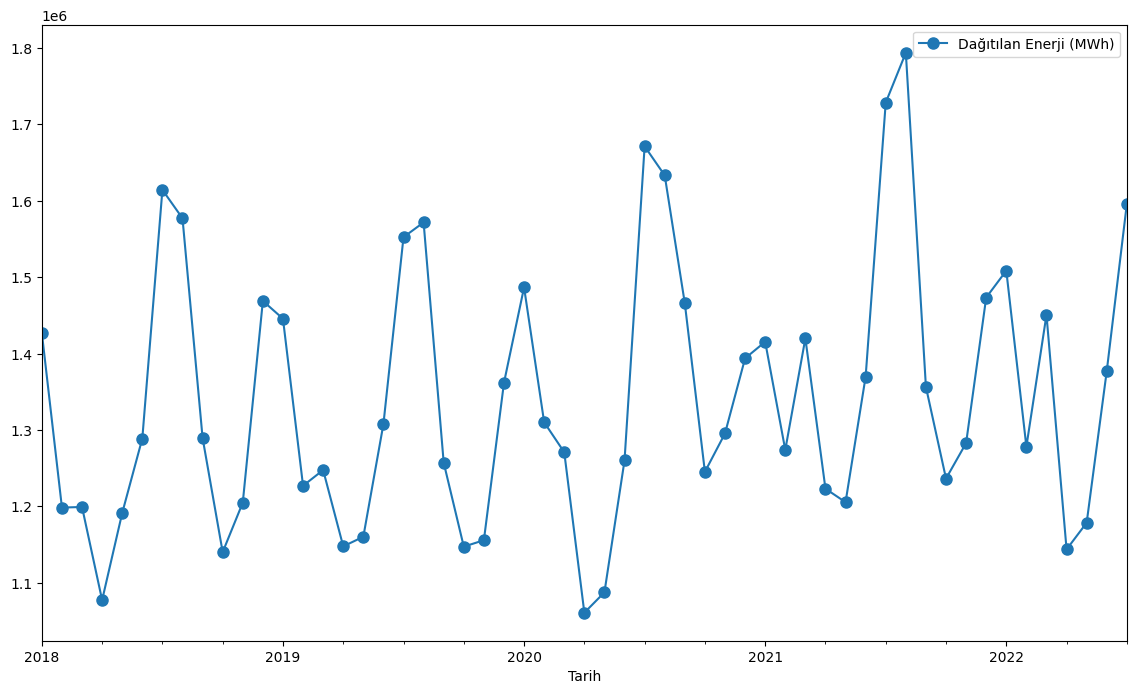

In [14]:
dfMonth.plot(figsize=(14,8),marker="o",markersize=8)

Adfuller durağanlık testi zaman serilerinde trend olup olmadığını kontrol etmektedir.<br>
Eğer p-value değeri 0.05 ten küçükse verinin durağan olduğunu söyleyebiliriz.<br>


In [15]:
df = dfMonth


from statsmodels.tsa.stattools import adfuller
result = adfuller(df)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -0.336503
p-value: 0.920173
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604


<Axes: xlabel='Tarih'>

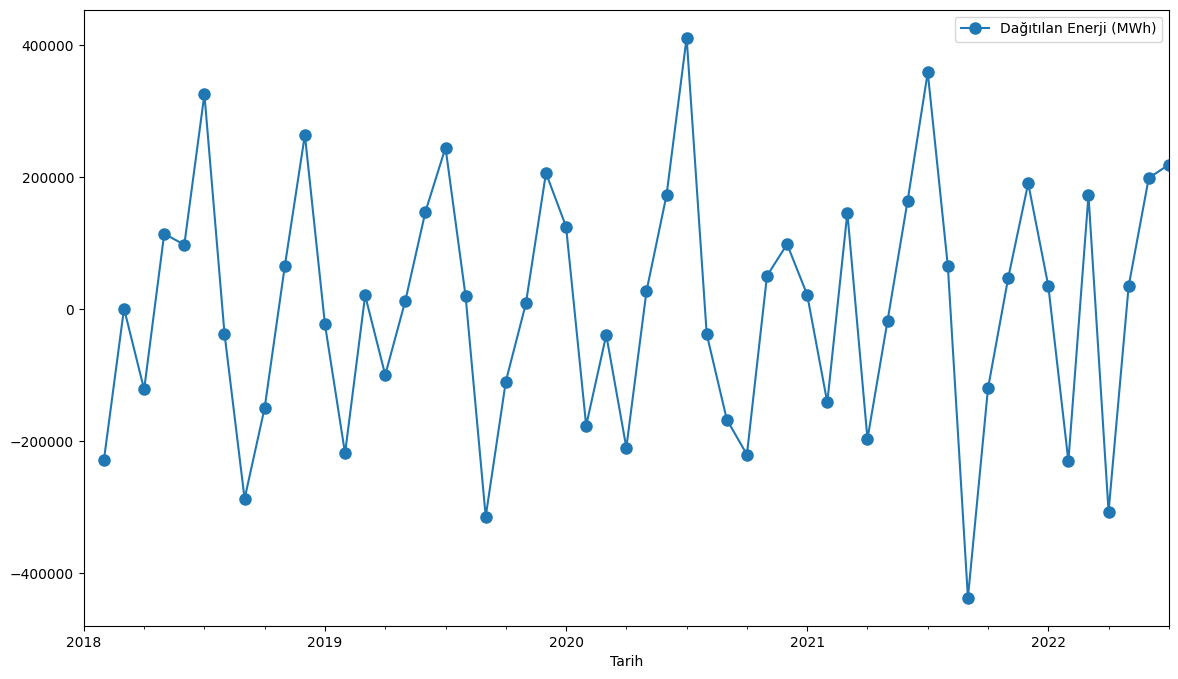

In [16]:
dfMonth.diff().plot(figsize=(14,8),marker="o",markersize=8)

In [17]:
#Birinci dereceden fark alındığında verinin p-value değeri 0.02 olarak bulunmuştur.
#Modele d = 1 değeri eklenmelidir.

from statsmodels.tsa.stattools import adfuller

result = adfuller(dfMonth.diff().dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.164486
p-value: 0.022135
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


In [32]:
#model = SARIMAX(df,order=(2,1,2) ,seasonal_order = (1,1,0,12) ) mape = 5,17

model = SARIMAX(df,order=(1,0,1) ,seasonal_order = (1,1,0,12) )
model_f = model.fit()

model_f.summary()

ValueError: ignored

In [19]:

df = dfMonth

Egitim = df[:40]
Test = df[40:]

start = len(Egitim)
end = len(Egitim) + len(Test)-1
predict = model_f.predict(start=start,end = end,typ='levels').rename('Test_Data').astype('int')
predict = pd.DataFrame(predict)

In [20]:
Test['Dağıtılan Enerji (MWh)'].sum()/predict['Test_Data'].sum()

1.0012519310559989

In [21]:

def Mape_Degeri(tahmin, test):
    mape = np.mean(np.abs(tahmin - test)/np.abs(test))*100  # MAPE
            # ACF1
    return mape
mape = Mape_Degeri(np.array(list(predict['Test_Data'])), np.array(list(Test['Dağıtılan Enerji (MWh)'])))
print("MAPE değeri {} olarak bulunmuştur. ".format(round(mape,2)))

MAPE değeri 4.32 olarak bulunmuştur. 


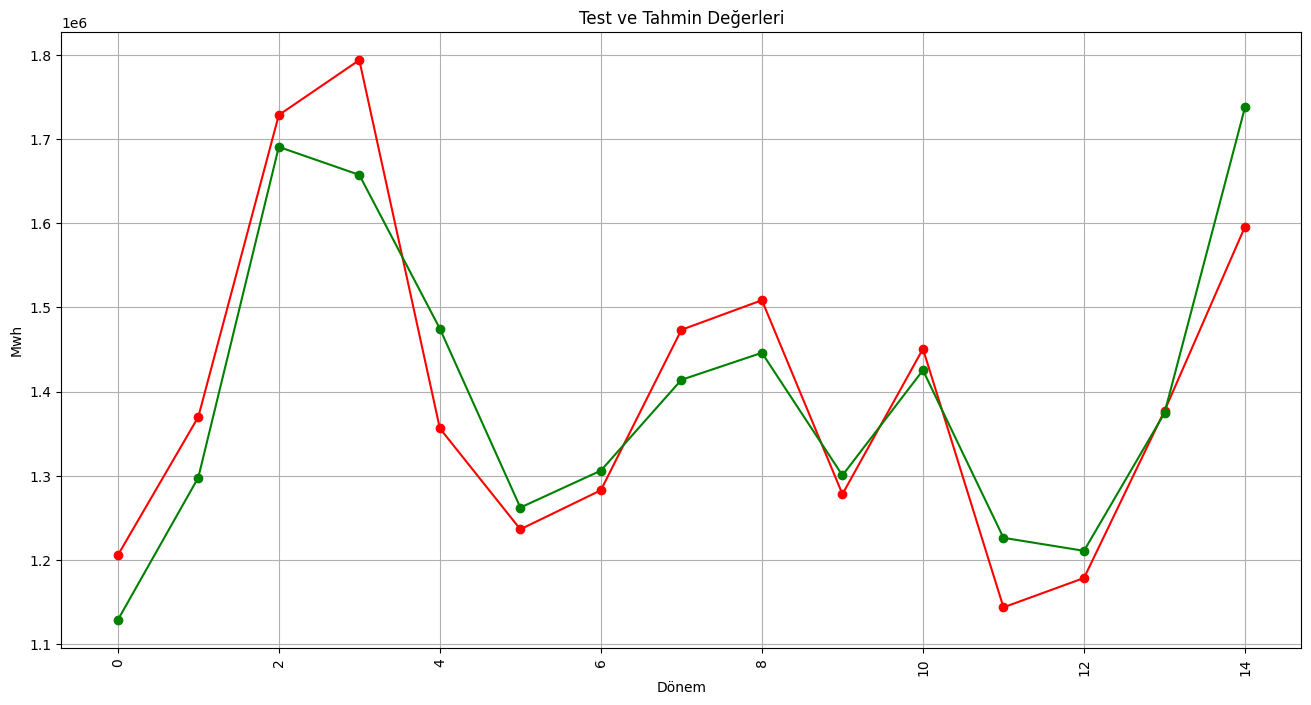

In [22]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(list(Test["Dağıtılan Enerji (MWh)"]),marker='o',color='red')
ax.plot(list(predict["Test_Data"]),marker='o',color='green')

ax.set(xlabel='Dönem', ylabel='Mwh',
       title='Test ve Tahmin Değerleri')
ax.grid()

plt.xticks(rotation = 90)
plt.show()

In [23]:
tahminx = model_f.forecast(steps=1).rename('Mwh').astype('int')
tahmin = pd.DataFrame(tahminx)
tahmin

,Mwh
2022-08,1789123


In [24]:
df = pd.read_csv("/content/train.csv",parse_dates=True)
df

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701
...,...,...
40147,2022-07-31 19:00:00,2492.489498
40148,2022-07-31 20:00:00,2479.958245
40149,2022-07-31 21:00:00,2485.016884
40150,2022-07-31 22:00:00,2396.574255


In [25]:
df08 = df[(df['Tarih'] > "2021-08-01") & (df['Tarih'] < "2021-09-01")]
df08

,Tarih,Dağıtılan Enerji (MWh)
31392,2021-08-01 00:00:00,2571.230740
31393,2021-08-01 01:00:00,2422.247527
31394,2021-08-01 02:00:00,2286.023672
31395,2021-08-01 03:00:00,2173.951400
31396,2021-08-01 04:00:00,2085.294765
...,...,...
32131,2021-08-31 19:00:00,2538.809761
32132,2021-08-31 20:00:00,2572.939106
32133,2021-08-31 21:00:00,2484.682803
32134,2021-08-31 22:00:00,2348.579241


In [26]:
df08["Dağıtılan Enerji (MWh)"].sum()

1793768.2071000002

In [27]:
df08['Saatlik%'] = df08['Dağıtılan Enerji (MWh)']/df08["Dağıtılan Enerji (MWh)"].sum()
df08['Tahmin'] = tahmin['Mwh'][0]
df08['Sonuc'] = df08['Saatlik%']*df08['Tahmin']
df08

,Tarih,Dağıtılan Enerji (MWh),Saatlik%,Tahmin,Sonuc
31392,2021-08-01 00:00:00,2571.230740,0.001433,1789123,2564.572188
31393,2021-08-01 01:00:00,2422.247527,0.001350,1789123,2415.974788
31394,2021-08-01 02:00:00,2286.023672,0.001274,1789123,2280.103703
31395,2021-08-01 03:00:00,2173.951400,0.001212,1789123,2168.321657
31396,2021-08-01 04:00:00,2085.294765,0.001163,1789123,2079.894610
...,...,...,...,...,...
32131,2021-08-31 19:00:00,2538.809761,0.001415,1789123,2532.235168
32132,2021-08-31 20:00:00,2572.939106,0.001434,1789123,2566.276130
32133,2021-08-31 21:00:00,2484.682803,0.001385,1789123,2478.248378
32134,2021-08-31 22:00:00,2348.579241,0.001309,1789123,2342.497276


In [28]:
dfsubmiss['Dağıtılan Enerji (MWh)']=list(df08['Sonuc'])
dfsubmiss

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,2564.572188
1,2022-08-01 01:00:00,2415.974788
2,2022-08-01 02:00:00,2280.103703
3,2022-08-01 03:00:00,2168.321657
4,2022-08-01 04:00:00,2079.894610
...,...,...
739,2022-08-31 19:00:00,2532.235168
740,2022-08-31 20:00:00,2566.276130
741,2022-08-31 21:00:00,2478.248378
742,2022-08-31 22:00:00,2342.497276


In [29]:
# dfsubmiss.to_csv('submissionMAPE4-32.csv', index = False)